# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

import logging
logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.WARN)

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [ ]:
env = UnityEnvironment(file_name='Reacher.app')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Approach

I took my earlier implementation on the __[navigation task](https://github.com/dahlem/deep-reinforcement-learning-navigation)__ and modularized the DDPG RL agent and actor/critic implementations. Both, the actor and critic can be configured to use LayerNorms in order to speed up learning with a larger learning rate. I introduced common random number generators to give each stochastic components its own seed to ensure that each component is decoupled. I used www.random.org to serialize 1000 seeds into a file, which is relayed through a seeds generator API.

### 4. Experiments

In the following sections I am going to present a serious of experiments that lead me to solve this environment. I had a few earlier attempts that performed poorly which I did not include. While I implemented a parallel agent environment, I did not complete a run. The following experiments are conducted on the single-agent environments but the number of udpate rounds is configurable and it works in conjunction with the configuration parameter to learn at every n-th step.

In [ ]:
%load_ext autoreload
%autoreload 2

#### 4.1 First Experiment

The first experiment uses a uniform replay buffer and actor/critic architectures with 256/256/64 neurons per layer each. The actor action values are fed into the critic in the second layer (which is also a configuration parameter. Noise is added and weight decay is applied to the critic.

This experiment did not result in any learned skill.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

import pandas as pd

import torch.nn.functional as F

from rl.ddpg_agent import DDPGAgent
from rl.train import train
from utils.rnd import Seeds

seedGenerator = Seeds('seeds')
seedGenerator.next()
from rl.buffer import UniformReplayBuffer


experience_params = {
    'seed': seedGenerator,       # seed for the experience replay buffer
    'buffer_size': 100000,        # size of the replay buffer
    'batch_size': 128            # batch size sampled from the replay buffer
}

experienceReplay = UniformReplayBuffer(experience_params)

params = {
    'name': 'DDPG-1',
    'episodes': 2000,            # number of episodes
    'maxlen': 100,               # sliding window size of recent scores
    'brain_name': brain_name,    # the brain name of the unity environment
    'achievement': 30.,           # score at which the environment is considered solved
    'environment': env,
    'agent_params': {
        'experience_replay': experienceReplay,
        'seed': seedGenerator,
        'num_agents': num_agents,    # number of agents in the environment
        'gamma': 0.99,               # discount factor
        'tau': 0.001,                # mixing rate soft-update of target parameters
        'update_every': 10,        # update every n-th step
        'num_updates': 5,            # we don't necessarily need to run as many rounds of updates as there are agents
        'add_noise': True,          # add noise using 'noise_params'
        'actor_params': {            # actor parameters
            'norm': False,
            'lr': 0.001,            # learning rate
            'state_size': state_size,    # size of the state space
            'action_size': action_size,  # size of the action space
            'seed': seedGenerator,                # seed of the network architecture
            'hidden_layers': [256, 256, 64], # hidden layer neurons
            'dropout': 0.05,
            'act_fn': [F.leaky_relu, F.leaky_relu, F.tanh]
        },
        'critic_params': {               # critic parameters
            'norm': False,
            'lr': 0.001,                 # learning rate
            'weight_decay': 0.001,          # weight decay
            'state_size': state_size,    # size of the state space
            'action_size': action_size,  # size of the action space
            'seed': seedGenerator,               # seed of the network architecture
            'hidden_layers': [256, 256, 64], # hidden layer neurons
            'dropout': 0.05,
            'action_layer': 1,
            'act_fn': [F.leaky_relu, F.leaky_relu, lambda x: x]
        },
        'noise_params': {            # parameters for the noisy process
            'mu': 0.,                # mean
            'theta': 0.15,           # theta value for the ornstein-uhlenbeck process
            'sigma': 0.2,            # variance
            'seed': seedGenerator,         # seed
            'action_size': action_size
        }
    }
}

agents = [DDPGAgent(idx=idx, params=params['agent_params']) for idx, a in enumerate(range(num_agents))]

scores = train(agents=agents, params=params)

df = pd.DataFrame(data={'episode': np.arange(len(scores)), 'DDPG-1': scores})
df.to_csv('results/DDPG-1-scores.csv', index=False)

#### 4.2 Second Experiments

The second experiment uses the same architecture but introduces normalising layers between the linear layers and the activation functions. Since we are using normalising layers we do not apply weight decay to the critic.

While this experiment did not solve the environment, it did result in a significant improvement over the previous experiment.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

import pandas as pd

import torch.nn.functional as F

from rl.ddpg_agent import DDPGAgent
from rl.train import train
from utils.rnd import Seeds

seedGenerator = Seeds('seeds')
seedGenerator.next()
from rl.buffer import UniformReplayBuffer


experience_params = {
    'seed': seedGenerator,       # seed for the experience replay buffer
    'buffer_size': 100000,        # size of the replay buffer
    'batch_size': 128            # batch size sampled from the replay buffer
}

experienceReplay = UniformReplayBuffer(experience_params)

params = {
    'name': 'DDPG-2',
    'episodes': 2000,            # number of episodes
    'maxlen': 100,               # sliding window size of recent scores
    'brain_name': brain_name,    # the brain name of the unity environment
    'achievement': 30.,           # score at which the environment is considered solved
    'environment': env,
    'agent_params': {
        'experience_replay': experienceReplay,
        'seed': seedGenerator,
        'num_agents': num_agents,    # number of agents in the environment
        'gamma': 0.99,               # discount factor
        'tau': 0.001,                # mixing rate soft-update of target parameters
        'update_every': 10,        # update every n-th step
        'num_updates': 5,            # we don't necessarily need to run as many rounds of updates as there are agents
        'add_noise': True,          # add noise using 'noise_params'
        'actor_params': {            # actor parameters
            'norm': True,
            'lr': 0.001,            # learning rate
            'state_size': state_size,    # size of the state space
            'action_size': action_size,  # size of the action space
            'seed': seedGenerator,                # seed of the network architecture
            'hidden_layers': [256, 256, 64], # hidden layer neurons
            'dropout': 0.05,
            'act_fn': [F.leaky_relu, F.leaky_relu, F.tanh]
        },
        'critic_params': {               # critic parameters
            'norm': True,
            'lr': 0.001,                 # learning rate
            'weight_decay': 0.0,          # weight decay
            'state_size': state_size,    # size of the state space
            'action_size': action_size,  # size of the action space
            'seed': seedGenerator,               # seed of the network architecture
            'hidden_layers': [256, 256, 64], # hidden layer neurons
            'dropout': 0.05,
            'action_layer': 1,
            'act_fn': [F.leaky_relu, F.leaky_relu, lambda x: x]
        },
        'noise_params': {            # parameters for the noisy process
            'mu': 0.,                # mean
            'theta': 0.15,           # theta value for the ornstein-uhlenbeck process
            'sigma': 0.2,            # variance
            'seed': seedGenerator,         # seed
            'action_size': action_size
        }
    }
}

agents = [DDPGAgent(idx=idx, params=params['agent_params']) for idx, a in enumerate(range(num_agents))]

scores = train(agents=agents, params=params)

df = pd.DataFrame(data={'episode': np.arange(len(scores)), 'DDPG-2': scores})
df.to_csv('results/DDPG-2-scores.csv', index=False)

#### 4.3 Third Experiment

The third experiment builds on the previous one and increases the neurons in the fully connected layers from 256/256/64 to 512/512/128 neurons.

This experiment was solved in 465 episodes.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

import pandas as pd

import torch.nn.functional as F

from rl.ddpg_agent import DDPGAgent
from rl.train import train
from utils.rnd import Seeds

seedGenerator = Seeds('seeds')
seedGenerator.next()
from rl.buffer import UniformReplayBuffer


experience_params = {
    'seed': seedGenerator,       # seed for the experience replay buffer
    'buffer_size': 100000,        # size of the replay buffer
    'batch_size': 128            # batch size sampled from the replay buffer
}

experienceReplay = UniformReplayBuffer(experience_params)

params = {
    'name': 'DDPG-3',
    'episodes': 2000,            # number of episodes
    'maxlen': 100,               # sliding window size of recent scores
    'brain_name': brain_name,    # the brain name of the unity environment
    'achievement': 30.,           # score at which the environment is considered solved
    'environment': env,
    'agent_params': {
        'experience_replay': experienceReplay,
        'seed': seedGenerator,
        'num_agents': num_agents,    # number of agents in the environment
        'gamma': 0.99,               # discount factor
        'tau': 0.001,                # mixing rate soft-update of target parameters
        'update_every': 10,        # update every n-th step
        'num_updates': 5,            # we don't necessarily need to run as many rounds of updates as there are agents
        'add_noise': True,          # add noise using 'noise_params'
        'actor_params': {            # actor parameters
            'norm': True,
            'lr': 0.001,            # learning rate
            'state_size': state_size,    # size of the state space
            'action_size': action_size,  # size of the action space
            'seed': seedGenerator,                # seed of the network architecture
            'hidden_layers': [512, 512, 128], # hidden layer neurons
            'dropout': 0.05,
            'act_fn': [F.leaky_relu, F.leaky_relu, F.tanh]
        },
        'critic_params': {               # critic parameters
            'norm': True,
            'lr': 0.001,                 # learning rate
            'weight_decay': 0.0,          # weight decay
            'state_size': state_size,    # size of the state space
            'action_size': action_size,  # size of the action space
            'seed': seedGenerator,               # seed of the network architecture
            'hidden_layers': [512, 512, 128], # hidden layer neurons
            'dropout': 0.05,
            'action_layer': 1,
            'act_fn': [F.leaky_relu, F.leaky_relu, lambda x: x]
        },
        'noise_params': {            # parameters for the noisy process
            'mu': 0.,                # mean
            'theta': 0.15,           # theta value for the ornstein-uhlenbeck process
            'sigma': 0.2,            # variance
            'seed': seedGenerator,         # seed
            'action_size': action_size
        }
    }
}

agents = [DDPGAgent(idx=idx, params=params['agent_params']) for idx, a in enumerate(range(num_agents))]

scores = train(agents=agents, params=params)

df = pd.DataFrame(data={'episode': np.arange(len(scores)), 'DDPG-3': scores})
df.to_csv('results/DDPG-3-scores.csv', index=False)

In [ ]:
env.close()

# Summary

Here we summarize the results and show the learning curves over 2000 episodes.

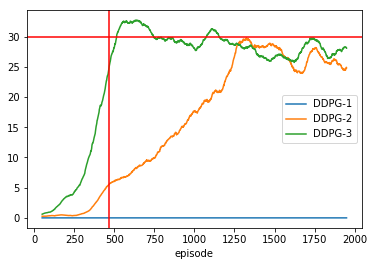

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import pandas as pd

achievementWindow = 100
df = pd.concat([pd.read_csv(f) for f in glob.glob('results/*-scores.csv')], axis=1)
df = df.loc[:,~df.columns.duplicated()]

dfRolling = df.rolling(achievementWindow).mean()
dfRolling.plot(x='episode', y=['DDPG-1', 'DDPG-2', 'DDPG-3'], kind='line')
solvedAt = dfRolling[dfRolling['DDPG-3']>=30.0].index[0] - achievementWindow
plt.axvline(x=solvedAt, color='red')
plt.axhline(y=30, color='red')